### MR files are nested in directories, make the structure flat

In [13]:
import glob

# Get all the MR files
mr_input_files = glob.glob('data_input/**/*.nii', recursive=True)

In [14]:
## are there any directories with multiple files?
from collections import defaultdict
import os

dir_files = defaultdict(list)
for file in mr_input_files:
    dir_files[os.path.dirname(file)].append(file)

for k, v in dir_files.items():
    if len(v) > 1:
        print(k, v)

print("Done")

Done


In [15]:
# create a bids dataset in data/mri
# folder structure should be data/mri/adni_thesis/sub-<subject_id>/ses-<session_id>

if not os.path.exists('data/mri/adni_thesis'):
    os.makedirs('data/mri/adni_thesis')

for file in mr_input_files:
    file_splits = file.split('/')

    adni_index = file_splits.index('ADNI')

    subject_id = file_splits[adni_index + 1].replace("_", "").replace(".", "").replace("-", "")
    session_id =  file_splits[adni_index + 3].replace("_", "").replace(".", "").replace("-", "")

    folder = f'data/mri/adni_thesis/sub-{subject_id}/ses-{session_id}/anat'
    if not os.path.exists(folder):
        os.makedirs(folder)

    new_file = f'{folder}/sub-{subject_id}_ses-{session_id}_T1w.nii'
    os.rename(file, new_file)


### Filter subjects where MR is available but no genome or vice vers


In [16]:
import re
mr_files = glob.glob('data/mri/*.nii')
genome_files = glob.glob('data/snps/*.vcf')

# mr subject name is between "ADNI_" and "_MR"
mr_split_regex = r'ADNI_(.*)_MR'
mr_subjects = [re.search(mr_split_regex, os.path.basename(file)).group(1) for file in mr_files]

# genome subject name is before "_SNPs"
genome_split_regex = r'(.*)_SNPs'
genome_subjects = [re.search(genome_split_regex, os.path.basename(file)).group(1) for file in genome_files]

mr_subjects = set(mr_subjects)
genome_subjects = set(genome_subjects)

# subjects with both MR and genome
both = mr_subjects.intersection(genome_subjects)

In [17]:
both

set()

In [21]:
# Run preprocessing pipeline
! smriprep-docker ./data/mri/adni_thesis ./data_processed/mri participant --fs-license-file ./license.txt

RUNNING: docker run --rm -e DOCKER_VERSION_8395080871=27.2.0 -it -v /Users/jonasfallmann/userdata/University/Master/Master Thesis/Practical Work/license.txt:/opt/freesurfer/license.txt:ro -v /Users/jonasfallmann/userdata/University/Master/Master Thesis/Practical Work/data/mri/adni_thesis:/data:ro -v /Users/jonasfallmann/userdata/University/Master/Master Thesis/Practical Work/data_processed/mri:/out nipreps/smriprep:0.16.1 /data /out participant
241125-12:26:19,259 nipype.workflow Level 25:
	 
    Running sMRIPrep version 0.16.1:
      * BIDS dataset path: /data.
      * Participant list: ['002S1155', '002S4262', '002S5256'].
      * Run identifier: 20241125-122619_5ecc2865-6061-4e0a-b1a3-7ad5f41c61b7.

    Spatial References: <none>.
    
241125-12:26:20,243 nipype.workflow INFO:
	 ANAT Stage 1: Adding template workflow
241125-12:26:20,469 nipype.workflow INFO:
	 ANAT Stage 2: Preparing brain extraction workflow
241125-12:26:20,776 nipype.workflow INFO:
	 ANAT Stage 3: Preparing segmen

In [64]:
import nibabel as nib

data = nib.load("data/mri/adni_thesis/sub-002S1155/ses-201401090945250/anat/sub-002S1155_ses-201401090945250_T1w.nii")
data_processed = nib.load("data_processed/mri/smriprep/sub-002S1155/ses-201401090945250/anat/sub-002S1155_ses-201401090945250_desc-preproc_T1w.nii.gz")

print(data.shape)
print(data_processed.shape)

(170, 256, 256)
(170, 256, 256)


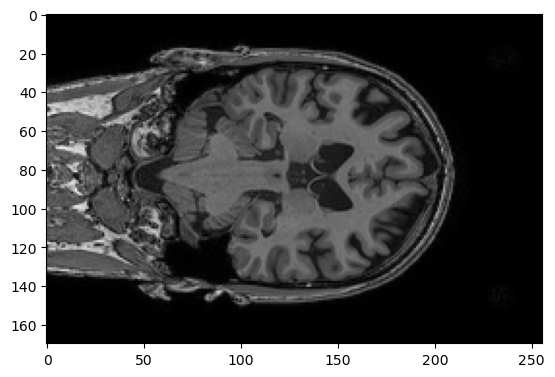

In [52]:
import matplotlib.pyplot as plt

plt.imshow(data.get_fdata()[:, 100, :], cmap='gray')

In [70]:
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from matplotlib import transforms


%matplotlib inline

def plot_func(slice):
    fig, axes = plt.subplots(1, 2, figsize=(18, 9))  # Create side-by-side subplots

    tr = transforms.Affine2D().rotate_deg(90)

    # Plot the first image
    axes[0].imshow(data.get_fdata()[:, :, slice], cmap='gray', origin='lower')
    axes[0].set_title(f'Image basic preprocessing - Slice {slice}')
    axes[0].axis('off')

    # Plot the second image
    axes[1].imshow(data_processed.get_fdata()[:, :, slice], cmap='gray', origin='lower')
    axes[1].set_title(f'Image preprocessed - Slice {slice}')
    axes[1].axis('off')

    plt.show()

# Interactive slider
interact(
    plot_func,
    slice=widgets.IntSlider(value=100, min=0, max=data.shape[1]-1, step=5)
)

interactive(children=(IntSlider(value=100, description='slice', max=255, step=5), Output()), _dom_classes=('wi…

<function __main__.plot_func(slice)>